In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
np.random.seed(42)
%matplotlib inline

In [2]:
data_dir = '/Users/mbedell/python/pmodes/experiments/data/'
import utils

In [3]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
xs_all = np.copy(d['xs'])

#### observe for 15 consecutive 1-min integrations every night

In [4]:
start_ts = np.arange(30,90) * 3600. * 24. # nightly for 60 consecutive nights
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [5]:
t = np.ravel([np.arange(15) * 60. + tt for tt in start_ts])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 0.5

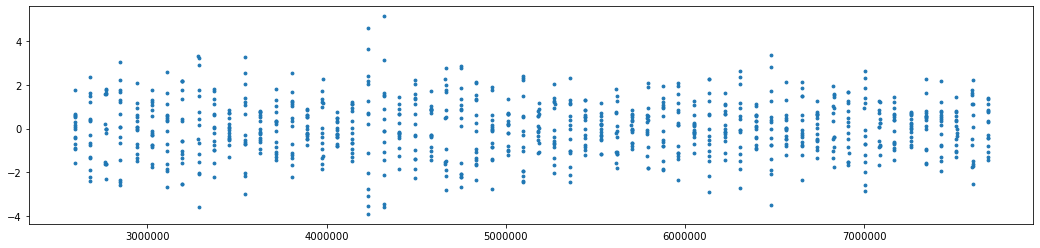

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t, y, s=8);

In [7]:
t_grid = np.ravel([np.linspace(t - 60, t + 900, 100) for t in start_ts]) # fine grid around the observed times

In [8]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(y)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
23it [00:00, 56.15it/s, logp=-8.309949e+02] 
message: Optimization terminated successfully.
logp: -1003.6837487153452 -> -830.9949448433914


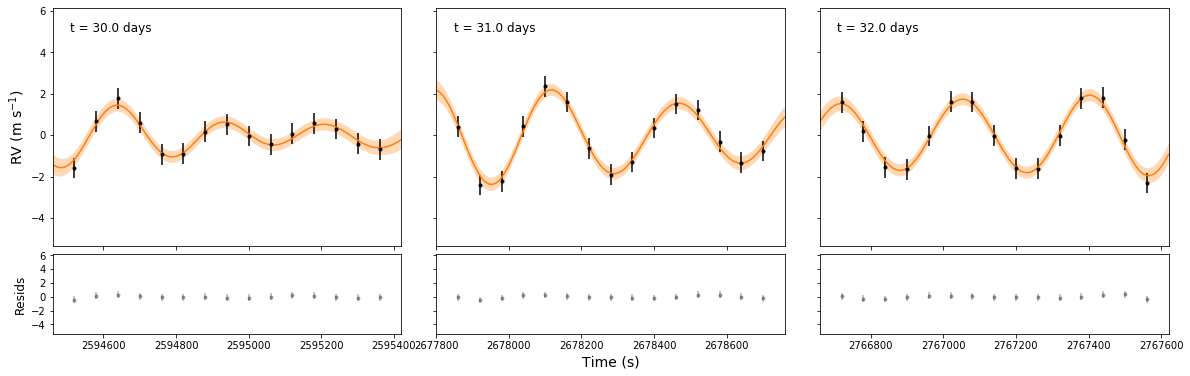

In [9]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)

In [10]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.18 m/s


#### 15 consecutive observations per night, but random nights

In [11]:
start_ts = np.random.choice(360, 60, replace=False) * 3600. * 24. # nightly for 60 random nights (we're gonna ignore seasons)
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts.sort()
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [12]:
t = np.ravel([np.arange(15) * 60. + tt for tt in start_ts])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 0.5

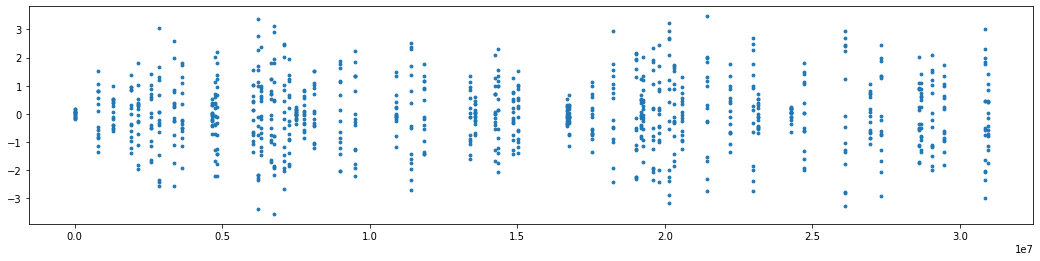

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t, y, s=8);

In [14]:
t_grid = np.ravel([np.linspace(t - 60, t + 900, 100) for t in start_ts]) # fine grid around the observed times

In [15]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(y)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
22it [00:00, 701.82it/s, logp=-7.856577e+02]
message: Optimization terminated successfully.
logp: -1000.7642281750957 -> -785.657701306852


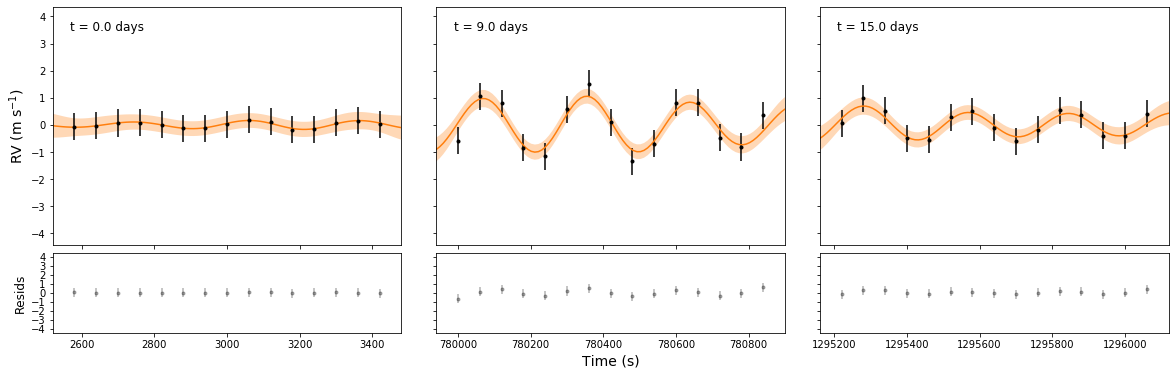

In [16]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)

In [17]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.20 m/s


#### random nights, longer exposures

In [18]:
exp_time = 5. * 60. # seconds per exposure
n_exp = 3 # consecutive exposures

t = []
y = []

for st in start_ts:
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        inds = (ts_all > stt - 900.) & (ts_all < stt + exp_time + 900.)
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], st, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)
yerr = np.zeros_like(t) + 0.5

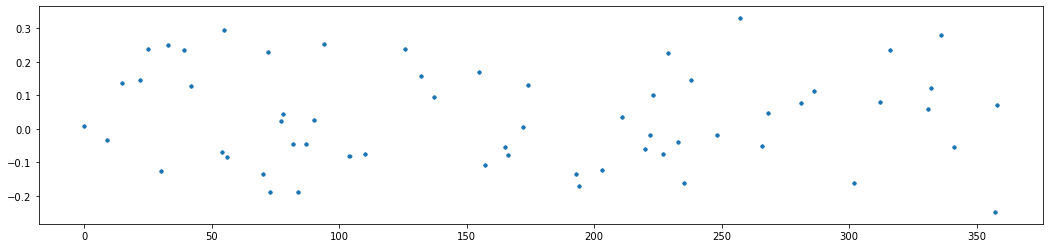

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t/24./3600., y, s=8);

In [20]:
t_grid = np.ravel([np.linspace(t - 60, t + 900, 100) for t in start_ts]) # fine grid around the observed times

In [21]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(y)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
34it [00:00, 824.59it/s, logp=-5.571277e+01] 
message: Optimization terminated successfully.
logp: -139.9866873293537 -> -55.712774220978844


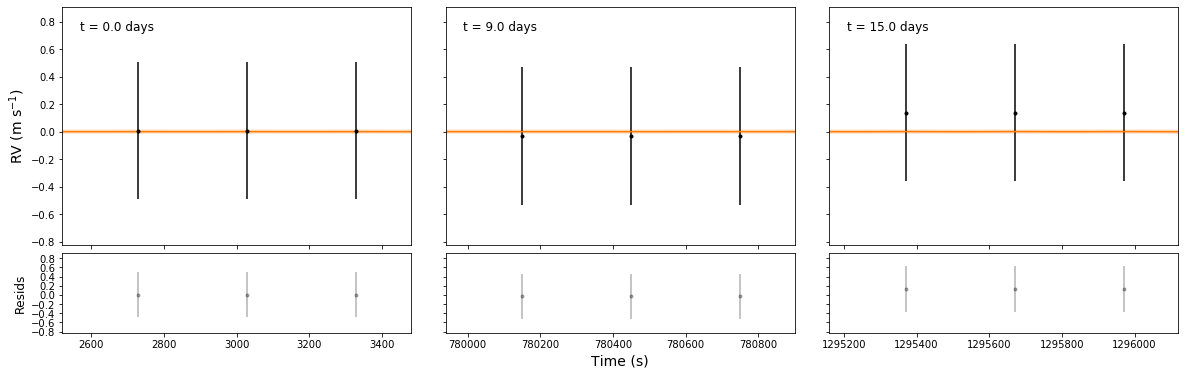

In [22]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)

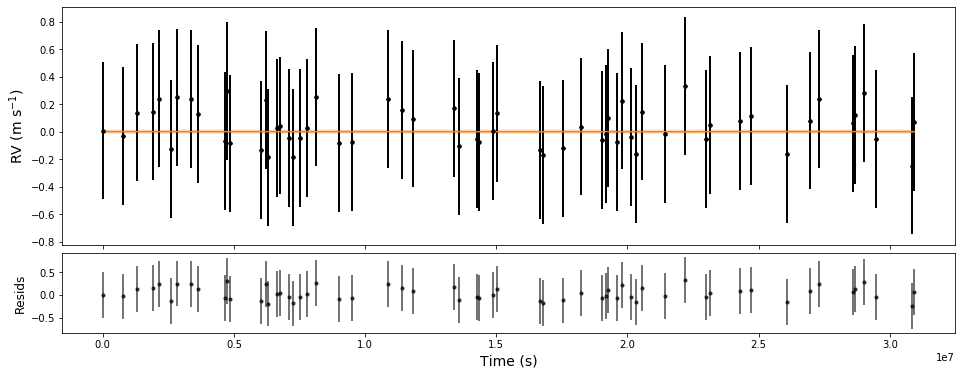

In [23]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)

In [24]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.15 m/s
